In [1]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')


In [2]:
from utils.THESIS import LightCurveSampler, JAXNSmodelCreator, ModelComparison
from utils.NSmodels import *

INFO[2026-02-05 18:57:31,872]: Unable to initialize backend 'cuda': 
INFO[2026-02-05 18:57:31,872]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2026-02-05 18:57:31,873]: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO[2026-02-05 18:57:32,021]: arviz_base not installed
INFO[2026-02-05 18:57:32,021]: arviz_stats not installed
INFO[2026-02-05 18:57:32,022]: arviz_plots not installed


#### Power spectrum models

In [3]:
def lorentz_q(f, lor_rmssq, f_pk, q):  
# Form of the Lorentzian function defined in terms of peak frequency and quality factor q
# e.g. see Pottschmidt et al. 2003, A&A, 407, 1039 for more info.
# This form is commonly used because f_pk corresponds to the peak that is seen when plotting
# the Lorentzian using frequency*power, so is more intuitive than using the centroid for the characteristic
# frequency.
    f_res=f_pk/np.sqrt(1.0+(1.0/(4.0*q**2)))
    r=np.sqrt(lor_rmssq)/np.sqrt(0.5-np.arctan(-2.0*q)/np.pi)
    powmod = ((1/np.pi)*2*r**2*q*f_res)/(f_res**2+(4*q**2*np.square(f-f_res)))
    return powmod

def lorentz_fwhm(f, lor_rmssq, f_cent, fwhm): 
# Traditional form of the Lorentzian function, with a centroid and FHWM
    powmod = lor_rmssq * (fwhm/(2.*np.pi))/((f-f_cent)**2 + (fwhm/2.)**2)
    return powmod

def bend_pl(f, norm, f_bend, alph_lo, alph_hi, sharpness):
    # Bending power-law with two slopes, modified from Summons et al. 2007 
    # (http://adsabs.harvard.edu/abs/2007MNRAS.378..649S)
    # to include 'sharpness' parameter.  Sharpness = 1 same as simpler Summons et al. model, larger values
    # give a sharper transition from one slope to the other.
    # Typical slopes for AGN would be alph_lo=-1, alph_hi=-2 to -3
    powmod = (norm*(f/f_bend)**alph_lo)/(1.+(f/f_bend)**(sharpness*(alph_lo-alph_hi)))**(1./sharpness)
    return powmod

def dbl_bend_pl(f, norm, f_bend_lo, f_bend_hi, alph_lo, alph_med, alph_hi, sharpness):
    # As bend_pl but now with two bends.  If AGN look like BHXRBs the low-frequency slope would be ~0,
    # with medium and high slopes like that for the single-bend case.  This shape could be mimicked by 
    # multiple Lorentzians
    powmod = (norm*(f/f_bend_lo)**alph_lo)/(1.+(f/f_bend_lo)**((sharpness*(alph_lo-alph_med)))*
        (1.+(f/f_bend_hi)**(sharpness*(alph_med-alph_hi))))**(1./sharpness)
    return powmod

def gaussian(f, f_peak, width, amplitude ):
    
    return amplitude * np.exp(-(f-f_peak)**2/2*width**2)
    
    
def bend_pl_lorentz(f, norm, f_bend, alph_lo, alph_hi, sharpness, lor_rmssq, f_pk, q):
    f_res=f_pk/np.sqrt(1.0+(1.0/(4.0*q**2)))
    r=np.sqrt(lor_rmssq)/np.sqrt(0.5-np.arctan(-2.0*q)/np.pi)
    powmod_lorentz = ((1/np.pi)*2*r**2*q*f_res)/(f_res**2+(4*q**2*np.square(f-f_res)))
    
    powmod_bend_pl = (norm*(f/f_bend)**alph_lo)/(1.+(f/f_bend)**(sharpness*(alph_lo-alph_hi)))**(1./sharpness)
    
    return powmod_bend_pl+powmod_lorentz

#### Lightcurve sampling

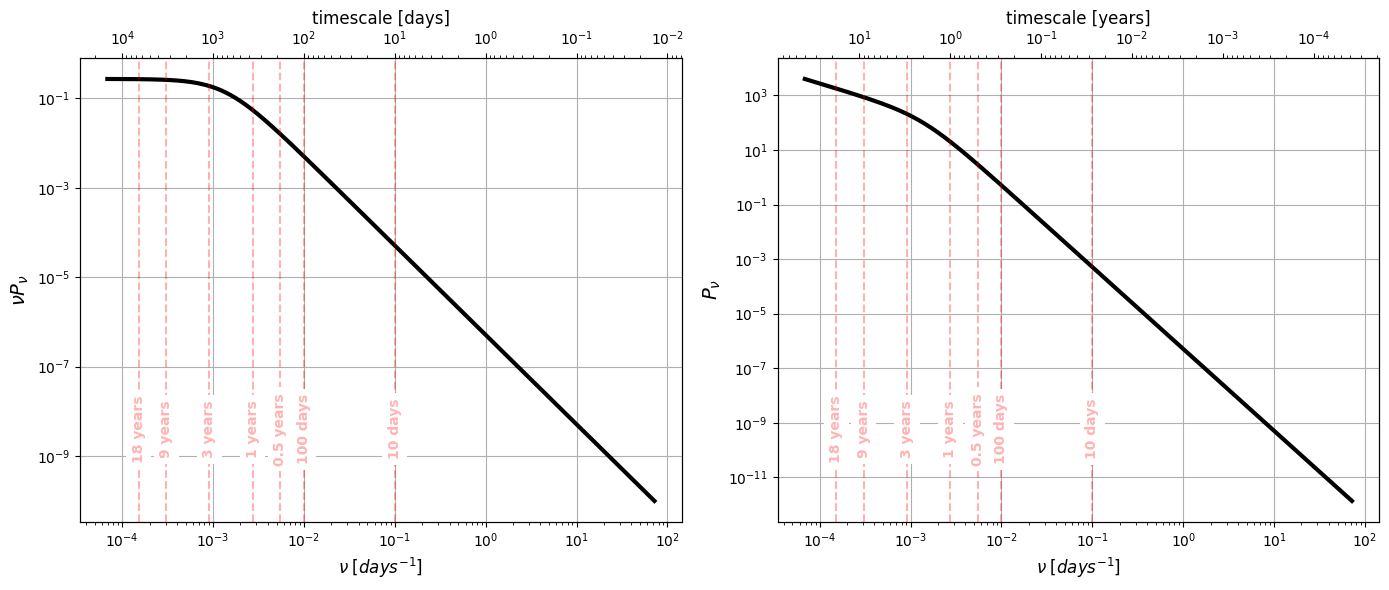

15795


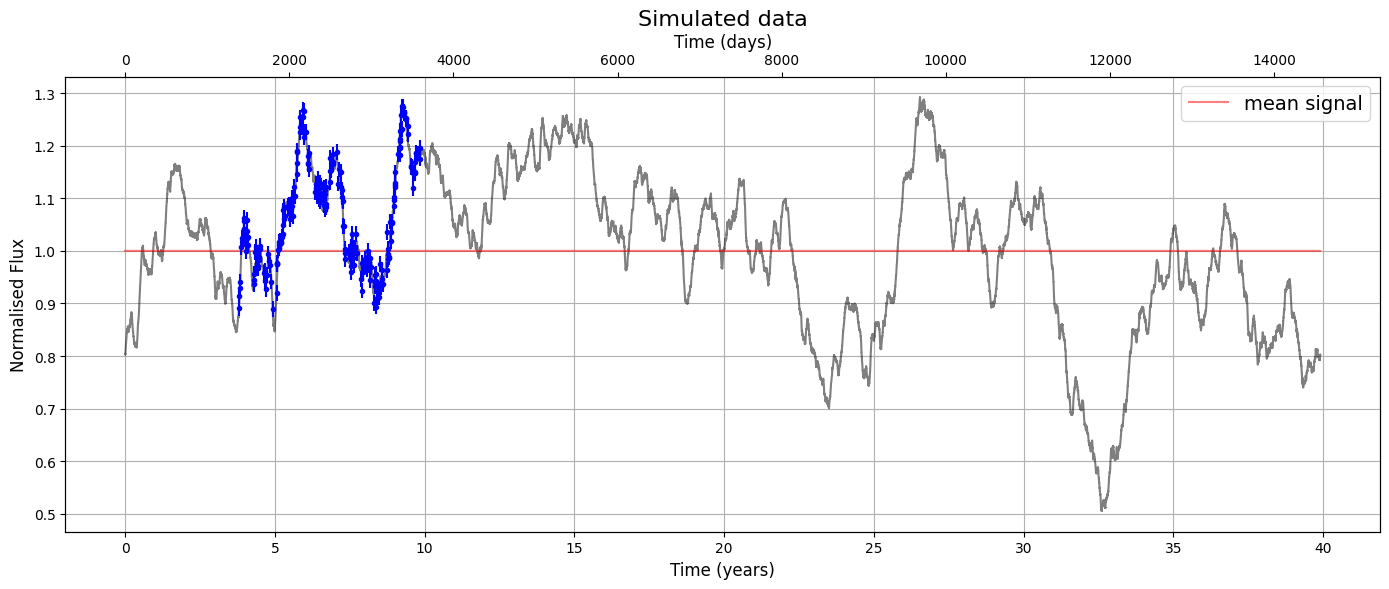

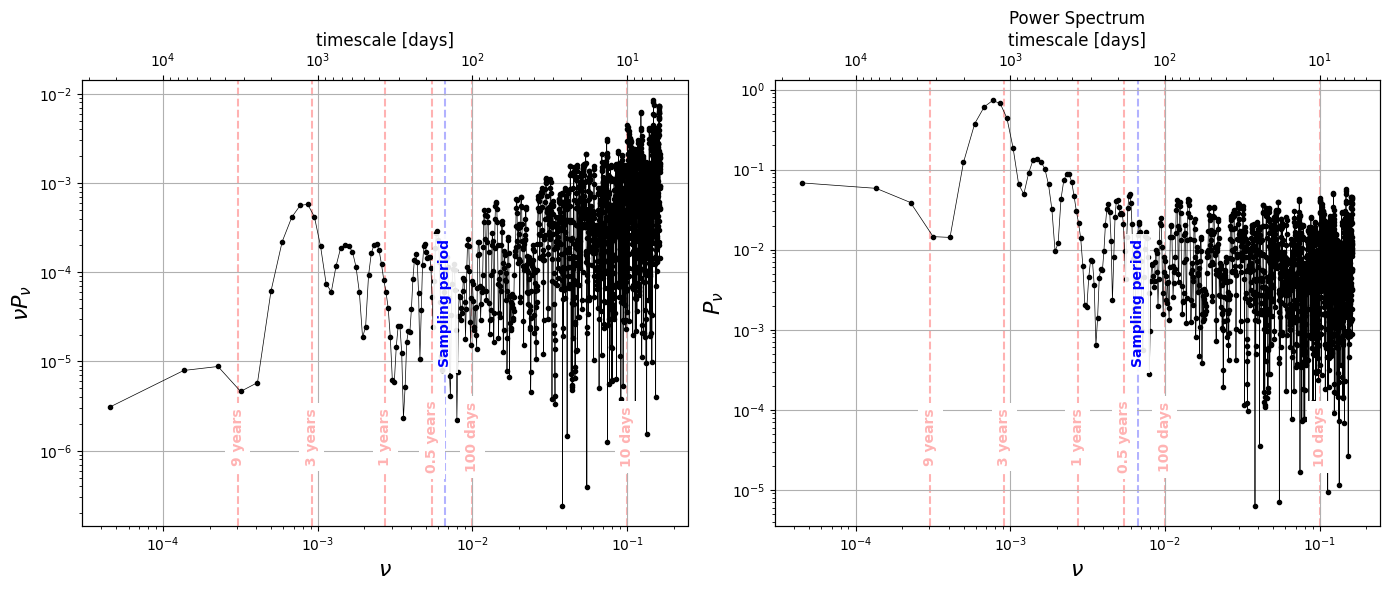

In [ ]:

np.random.seed(42)
rand = np.random.randint(0, 100000)
l = LightCurveSampler(N=2**21, rms=0.15, simulatorSEED= rand , verbose=False)
l.load_powerspec(bend_pl, [200,  0.5/365,  -1,-3,1], plot=True) # turn off in 1/days
l.LCsimulator()
np.random.seed(42) 
simTIME, simLC, simLCerr , lc = l.sampler(NightsperWINDOW = 20, NumofWINDOW = 15 , OBSperiod = 5, WINDOWwidth = 120, samplerSEED=1000,
                                        dataLOSSfrac=0.2, noiseSIGMA=0.015, plot=True)



#### Nested sampling

In [ ]:

lcTIME = simTIME - np.mean(simTIME)
lcFLUX = simLC - np.median(simLC)
lcFLUXerr = simLCerr

# creates a jaxns model given the prior and loglikelihood model
modelCreater = JAXNSmodelCreator(lcTIME, lcFLUX, lcFLUXerr)

DRW_NSmodel = modelCreater.create_model(DRW_generative_prior, DRW_log_likelihood_model)
DRW_linear_NSmodel = modelCreater.create_model(DRW_linear_generative_prior, DRW_linear_log_likelihood_model)

DRW_sine_NSmodel = modelCreater.create_model(DRW_sine_generative_prior, DRW_sine_log_likelihood_model)
DRW_sine_linear_NSmodel = modelCreater.create_model(DRW_sine_linear_generative_prior, DRW_sine_linear_log_likelihood_model)

CARMA21_NSmodel = modelCreater.create_model(create_CARMA_JAXNS_model_funcs(2,1, functype="prior"), 
                                                    create_CARMA_JAXNS_model_funcs(2,1, functype="likelihood"))

OBPL_10_NSmodel = modelCreater.create_model(OBPL_generative_prior, OBPL_log_likelihood_model, n_component = 10)
OBPLsine_10_NSmodel = modelCreater.create_model(OBPLsine_generative_prior, OBPLsine_log_likelihood_model, n_component = 10)



# Uses the created jaxns models and uses it to do nested sampling
ModelCOMP = ModelComparison(lcTIME, lcFLUX,lcFLUXerr, verbose=True)
ModelCOMP.add_NestedModel(DRW_NSmodel, 'DRW')
ModelCOMP.add_NestedModel(DRW_sine_NSmodel, 'DRWsine')
ModelCOMP.add_NestedModel(CARMA21_NSmodel, 'CARMA21')
ModelCOMP.add_NestedModel(OBPL_10_NSmodel, 'OBPL10')
ModelCOMP.add_NestedModel(OBPLsine_10_NSmodel, 'OBPLsine10')


Model Comparion object created.
JAXNS model added.
JAXNS model added.
JAXNS model added.
JAXNS model added.
JAXNS model added.


In [8]:
ModelCOMP.models()

['CARMA21', 'DRW', 'DRWsine', 'OBPL10', 'OBPLsine10']

In [9]:
ModelCOMP.run_NSsampler()

Total number of models being sampled :  5
--------------------------------------------------------------------------
Model being sampled :  CARMA21
-------------------------------------------------------------------------
DefaultNestedSampler Created. 
Sampling inititated.
Sampling finished.
TerminationCondition :  Small remaining evidence


Model being sampled :  DRW
-------------------------------------------------------------------------
DefaultNestedSampler Created. 
Sampling inititated.
Sampling finished.
TerminationCondition :  Small remaining evidence


Model being sampled :  DRWsine
-------------------------------------------------------------------------
DefaultNestedSampler Created. 
Sampling inititated.
Sampling finished.
TerminationCondition :  Small remaining evidence


Model being sampled :  OBPL10
-------------------------------------------------------------------------
DefaultNestedSampler Created. 
Sampling inititated.
Sampling finished.
TerminationCondition :  Small r

In [11]:
ModelCOMP.pretty_print()

+-----------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+
|                       |           CARMA21            |             DRW              |           DRWsine            |            OBPL10            |          OBPLsine10          |
+-----------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+
|  Number of Parameters |              4               |              2               |              5               |              4               |              7               |
| Termination condition | ['Small remaining evidence'] | ['Small remaining evidence'] | ['Small remaining evidence'] | ['Small remaining evidence'] | ['Small remaining evidence'] |
|          logZ         |      538.5165553931947       |      535.1718288556095       |      53

In [12]:
DRW_dict = ModelCOMP.return_samples_logZ_dict('DRW')
DRWsine_dict = ModelCOMP.return_samples_logZ_dict('DRWsine')
CARMA21_dict = ModelCOMP.return_samples_logZ_dict('CARMA21')
OBPL_dict = ModelCOMP.return_samples_logZ_dict('OBPL10')
OBPLsine_dict = ModelCOMP.return_samples_logZ_dict('OBPLsine10')

